The "Emotions" dataset is a collection of English Twitter messages meticulously annotated with six primary emotions: anger, fear, joy, love, sadness, and surprise. The goal of using this data is to gain insights into the emotional spectrum expressed in short-form text on social media, offering valuable resources for understanding and analyzing patterns of emotional expression in online communication

In [1]:
# Installing necessary dependencies

%pip install pandas seaborn matplotlib plotly wordcloud -U kaleido


In [2]:
# Necessary imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import nltk

from plotly import graph_objs as go
from wordcloud import WordCloud
from collections import Counter
from typing import List, Tuple
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

pd.options.mode.chained_assignment = None


**PART 1 - EDA**

In [3]:
emotions_df = pd.read_csv("text.csv")
emotions_df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [4]:
# Dropping irrelevant column

emotions_df = emotions_df.drop(["Unnamed: 0"], axis=1)
emotions_df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


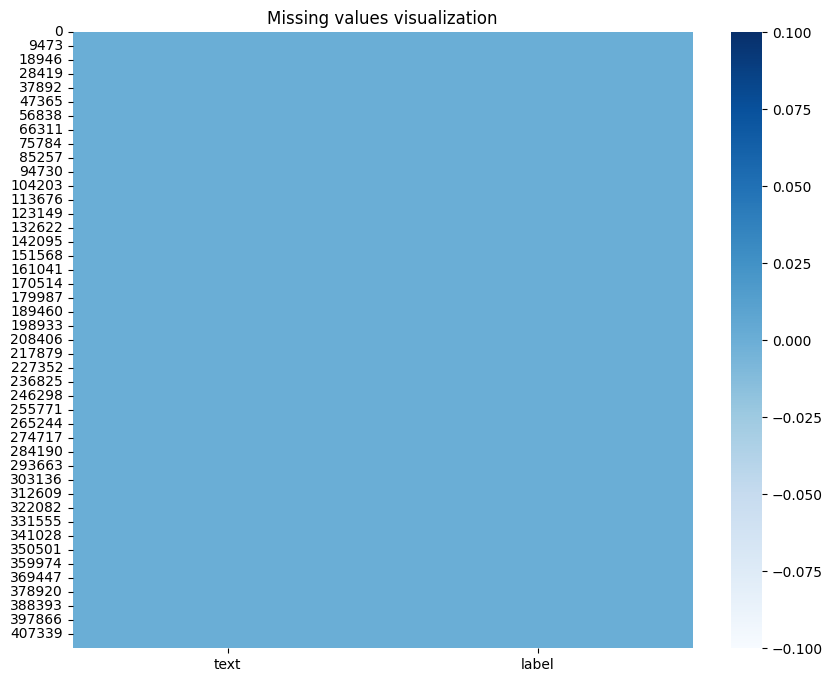

In [5]:
# Checking the presence of missing values

plt.figure(figsize=(10, 8))
sns.heatmap(emotions_df.isna(), cmap="Blues")
plt.title("Missing values visualization")
plt.show()

There are no missing values in this dataset

In [6]:
# Checking for duplicates, as duplicates can lead to inaccurate analysis, biased models, and inefficient resource use

emotions_df.duplicated().sum()

686

In [7]:
# Dropping duplicates

emotions_df = emotions_df.drop_duplicates()

**Visualizing the distribution of the target class**

For better readability, I will convert the encoded labels into their correspoding emotions - the emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)

In [8]:
label_to_emotion = {
    0 : "sadness",
    1 : "joy",
    2 : "love",
    3 : "anger",
    4 : "fear",
    5 : "surprise"
}

In [9]:
emotions_df["label_decoded"] = emotions_df["label"].apply(lambda x: label_to_emotion.get(x))

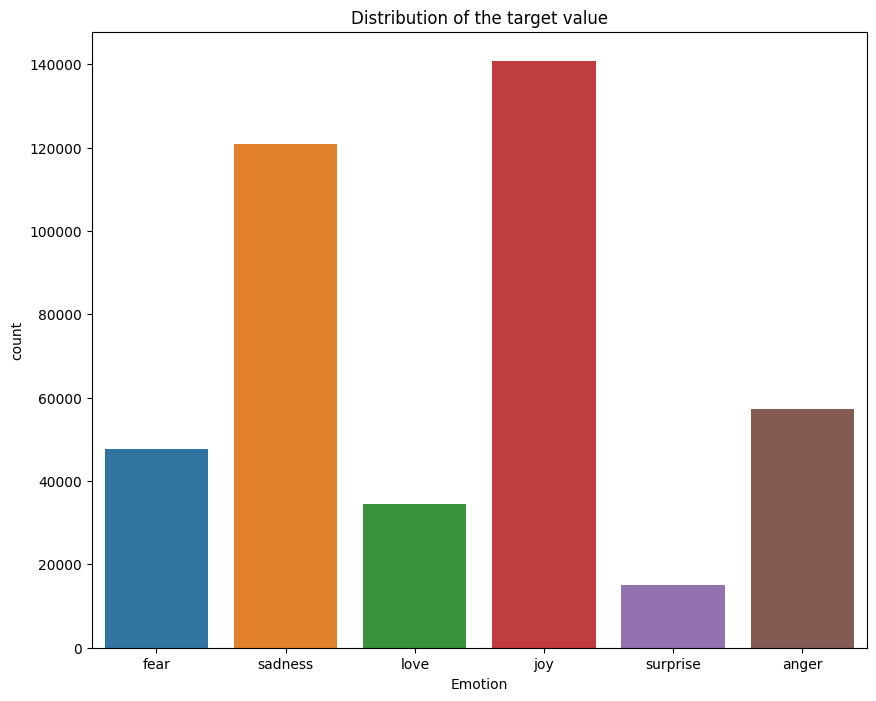

In [10]:
plt.figure(figsize=(10, 8))

sns.countplot(x=emotions_df["label_decoded"], hue=emotions_df["label_decoded"])
plt.title("Distribution of the target value")
plt.xlabel("Emotion")
plt.show()

It is clearly visible, that in this dataset we deal with class imbalance. Recognizing and addressing class imbalance is crucial for developing robust and fair machine learning models that accurately capture the underlying patterns in the data, as machine learning models trained on imbalanced data might become biased.

In [11]:
# This dataset is created for the visualization purposes - it includes the name of each emotion and the corresponding frequency of occurrences of that emotion within the dataset

emotions_count_df = emotions_df.groupby("label_decoded")["text"].count().reset_index().sort_values(by="text", ascending=False)

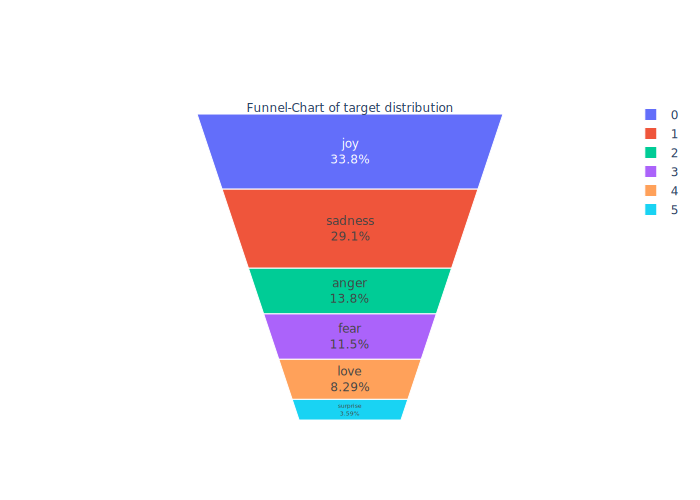

In [12]:
fig = go.Figure(go.Funnelarea(
    text = emotions_count_df.label_decoded,
    values = emotions_count_df.text,
    title = {"position": "top center", "text": "Funnel-Chart of target distribution"}
    ))
fig.show("svg")

In this dataset, joy is the most popular emotion, which is expected since people generally prefer to share positive news on social media platforms. Conversely, surprise ranks as the least popular emotion.

**Visualizing and analyzing the word frequencies**

Now, let's delve more into the text data itself. A word cloud is a data visualization technique that might be useful here, as it displays the most frequently occurring words in a text corpus. The purpose of a word cloud is to provide a visual representation of the prominent words within the text data, where the size of each word corresponds to its frequency of occurrence

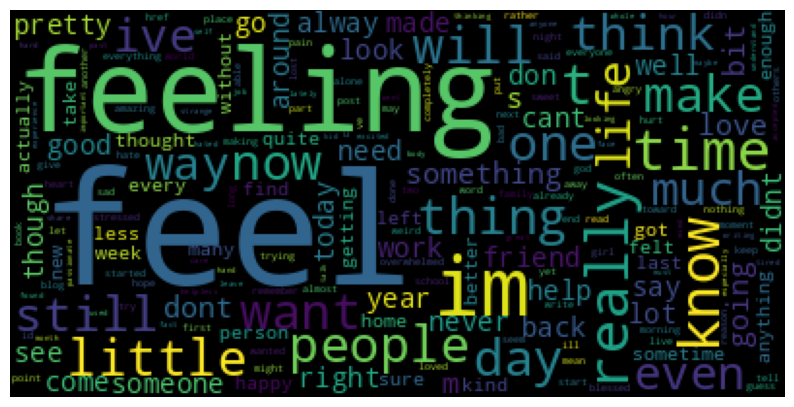

In [13]:
# Convert the text data to strings and concatenate them
text_data = ' '.join(emotions_df["text"].astype(str))

# Generate the WordCloud
wc = WordCloud(collocations=False).generate(text_data)

plt.figure(figsize=(10, 8))
plt.imshow(wc)
plt.axis("off")
plt.show()

It's evident that "feel" and "feeling" are the most common words in the text. These words are highly prominent, especially in discussions related to emotions

**Word clouds are visually striking but lack depth in conveying meaningful information beyond a few highlighted words. On the other hand, while bar plots may not be as visually appealing, they offer a more informative representation of data, making it easier to analyze and interpret. Now, let's take a look at some bar plots to dive deeper into the textual data**

In [14]:
def create_corpus(text: str) -> List[str]:
    text_list = text.split()
    return text_list

In [15]:
emotions_df['text_list'] = emotions_df['text'].apply(create_corpus)

In [16]:
corpus = []
for text_list in emotions_df['text_list']:
    corpus.extend(text_list)

In [17]:
most_common_words = Counter(corpus).most_common(15)
most_common_words

[('i', 675350),
 ('feel', 289391),
 ('and', 250153),
 ('to', 232955),
 ('the', 216507),
 ('a', 162780),
 ('feeling', 134036),
 ('that', 130663),
 ('of', 129922),
 ('my', 111136),
 ('in', 86381),
 ('it', 84414),
 ('like', 73881),
 ('so', 64923),
 ('for', 64019)]

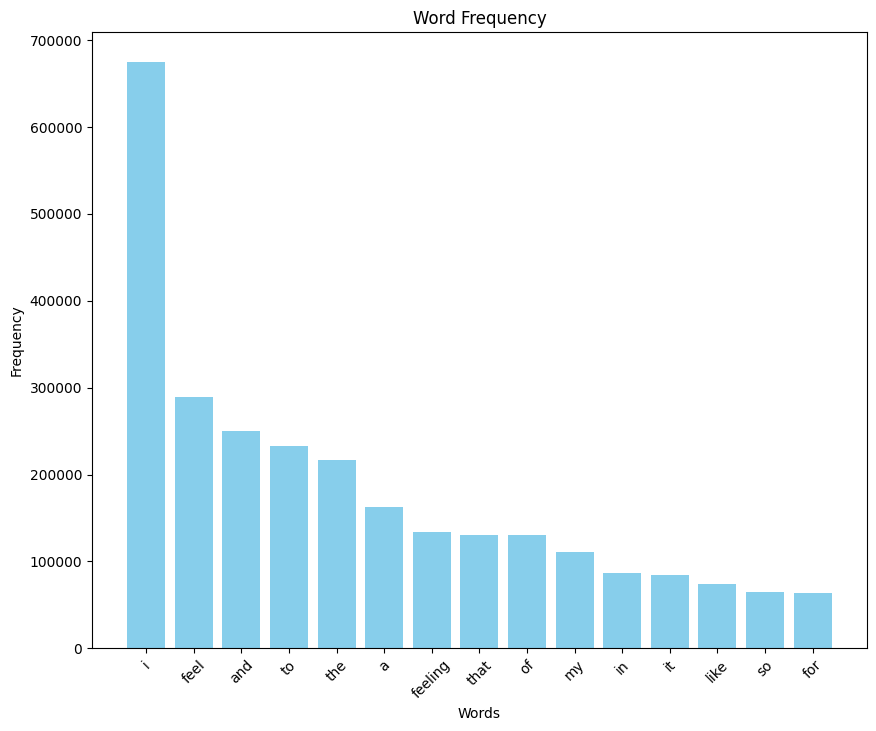

In [18]:
# Unzip the list of tuples into two lists
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency')
plt.xticks(rotation=45)
plt.show()

This plot provides valuable insights into our data. Notably, words like "feel" and "feeling" hold significant prominence, consistent with our observations from the word cloud. However, beyond these, the plot mainly showcases common stopwords that don't contribute much to our analysis. The word "I" emerges as the most frequently used term, which is expected given its common usage in personal expressions. We'll address stopwords during the preprocessing step to refine our dataset for more meaningful analysis.

We could also analyze the word frequency for each emotion separately, but this can also be done after processing, as it will be more informative.

**Exploring the relationship between text length and emotion**

As part of our exploratory data analysis (EDA), we can investigate whether there's a relationship between the length of messages and the expressed emotion.

In [19]:
def message_length(words: List[str]) -> int:
  length = len(words)
  return length

In [20]:
emotions_df['text_length'] = emotions_df['text_list'].apply(message_length)

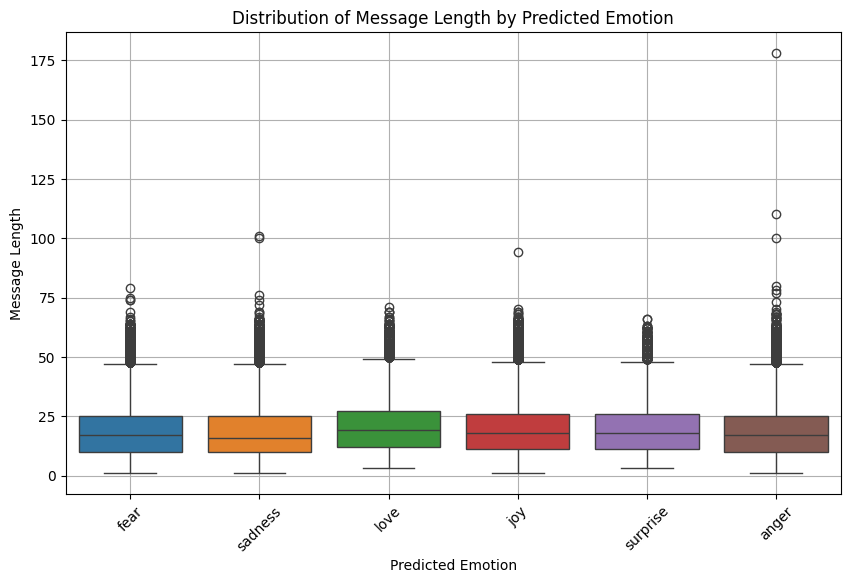

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label_decoded', y='text_length', hue='label_decoded', data=emotions_df)
plt.xlabel('Predicted Emotion')
plt.ylabel('Message Length')
plt.title('Distribution of Message Length by Predicted Emotion')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Looking at this boxplot, we can see that for each predicted emotion, the median text length is similar. It implies that the central tendency of text length remains consistent across different emotions. This observation suggests that text length might not be associated with the predicted emotion.
Among all the text messages analyzed, the longest outlier, i.e., the text with the greatest length compared to others, is associated with someone experiencing anger


**PART 2 - DATA PREPROCESSING**

Text preprocessing is essential for transforming raw text data into a format that is suitable for analysis and machine learning models.

We need to start of with cleaning our data - this step is really important, as it helps to extract only the relevant information from the corpus. Raw text data may include punctuation, numbers, links etc. that are not informative and can lead to lower model accuracy.

In [22]:
def clean_data(text: str) -> str:

  # Converting all characters to lowercase
  text = text.lower()

  # Removing links
  text = re.sub('https?://\S+|www\.\S+', '', text)

  # Removing HTML tags
  text = re.sub('<.*?>+', '', text)

  # Removing usernames
  text = re.sub('@[^\s]+', ' ', text)

  # Removing words that contain digits (ex. h3llo)
  text = re.sub('\w*\d\w*', '', text)

  # Removing single characters
  text = re.sub(r'\b\w\b', '', text)

  # Removing everything except letters from the text - it includes removing punctuation, digits, special characters
  text = re.sub(r'[^a-z\s]', ' ', text).strip()

  # Removing whitespace
  text = " ".join(text.split())

  # Removing newline characters
  text = re.sub('\n', '', text)


  return text


After cleaning our data, we can focus on removing stopwords and lemmatization. Stop word removal is a crucial text preprocessing step in sentiment analysis that involves removing common and irrelevant words that are unlikely to convey much sentiment. Lemmatization is a technique used to reduce words to their root forms. It involves reducing words to their base form based on their part of speech. By reducing words to their base form, lemmatization reduces the dimensionality of the feature space, which can lead to better model performance.

In [23]:
nltk.download('all', quiet=True)

True

In [24]:
def remove_stopwords_and_lemmatize(text: str) -> str:

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]


    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

In [25]:
emotions_df["text"] = emotions_df["text"].apply(clean_data)
emotions_df["text"] = emotions_df["text"].apply(remove_stopwords_and_lemmatize)

After completing those steps, our text data is in a format that is way more suitable for analysis. Before moving further, we can visualize preproccesed data as it yields more informative insights compared to visualizing raw text data. The initial visualizations were mostly used to get a grip of what the dataset holds - now the created plots will help us understand better what the data reveals.

Let's redo the word frequency plot to illustrate how cleaning data affects the distribution of word frequencies.

In [26]:
emotions_df['text_list_cleaned'] = emotions_df['text'].apply(create_corpus)


In [27]:
corpus = []
for text_list in emotions_df['text_list_cleaned']:
    corpus.extend(text_list)

In [28]:
most_common_words = Counter(corpus).most_common(15)
most_common_words

[('feel', 298251),
 ('feeling', 142615),
 ('like', 74176),
 ('im', 61554),
 ('really', 25852),
 ('time', 25471),
 ('know', 24411),
 ('get', 20602),
 ('little', 19196),
 ('make', 18861),
 ('people', 18529),
 ('would', 17952),
 ('thing', 17819),
 ('want', 17363),
 ('one', 17311)]

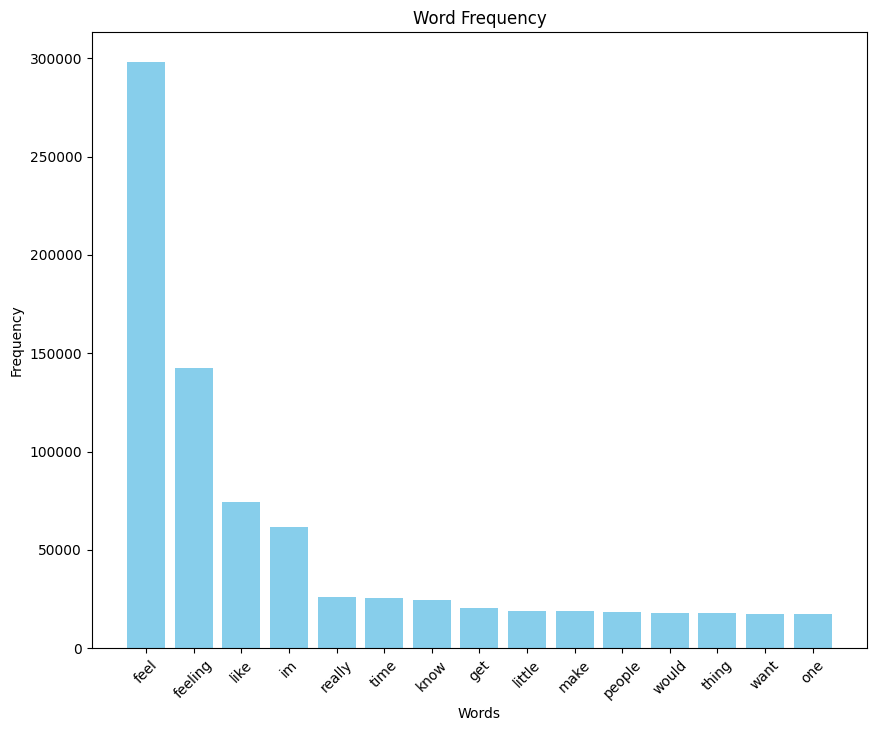

In [29]:
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency')
plt.xticks(rotation=45)
plt.show()

By comparing those two plots, a striking contrast becomes apparent. This is mostly due to stop words removal. This newly created plot reveals a more refined representation of the text's content. Words with semantic significance,now emerge as the most frequent, providing deeper insights into the underlying themes and topics present in the text.
"Feel" and "feeling" appear as two leading words, which is not surprising since we are analyzing emotion-related entries.

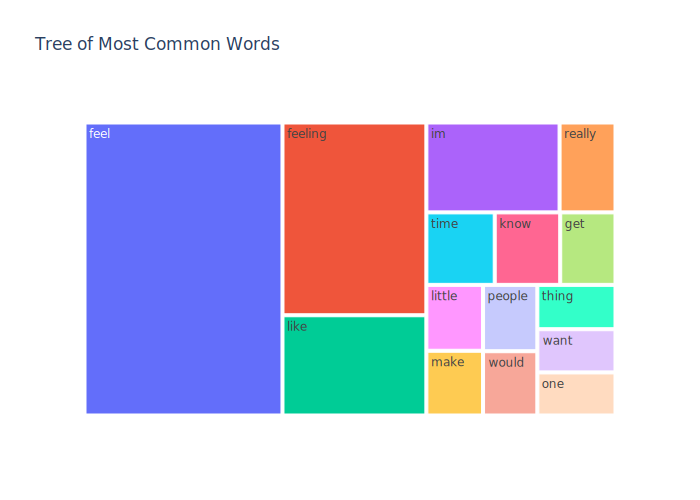

In [30]:
data = {"words": words, "values": frequencies}

fig = px.treemap(data, path=["words"], values="values",title='Tree of Most Common Words')
fig.show("svg")

What might be interesting is delving into the exploration of emotions by visualizing the most common words associated with distinct emotional states that are present in the dataset

In [31]:
# This utility function brings the preceding code together and serves as a versatile tool for analyzing and visualizing emotional content within textual data

def common_words_by_emotion(emotion: str) -> None:
  corpus = []
  for text_list in emotions_df.loc[emotions_df['label_decoded'] == emotion, 'text_list_cleaned']:
      corpus.extend(text_list)
  most_common_words = Counter(corpus).most_common(15)
  words, frequencies = zip(*most_common_words)
  data = {"words": words, "values": frequencies}

  fig = px.treemap(data, path=["words"], values="values",title=f'Tree of Most Common Words for {emotion}')
  fig.show("svg")

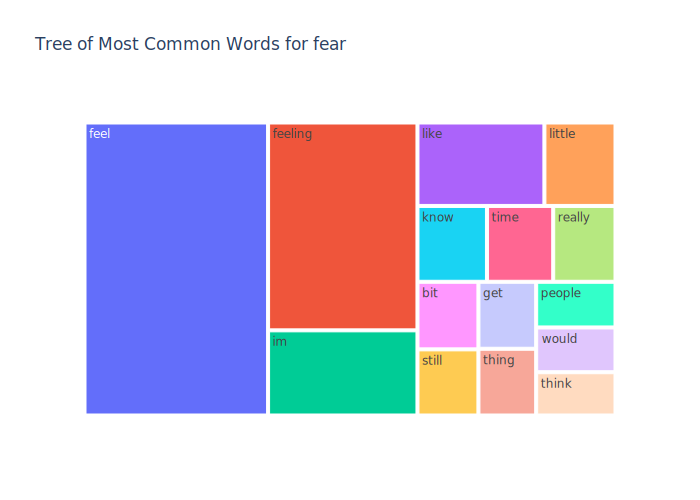

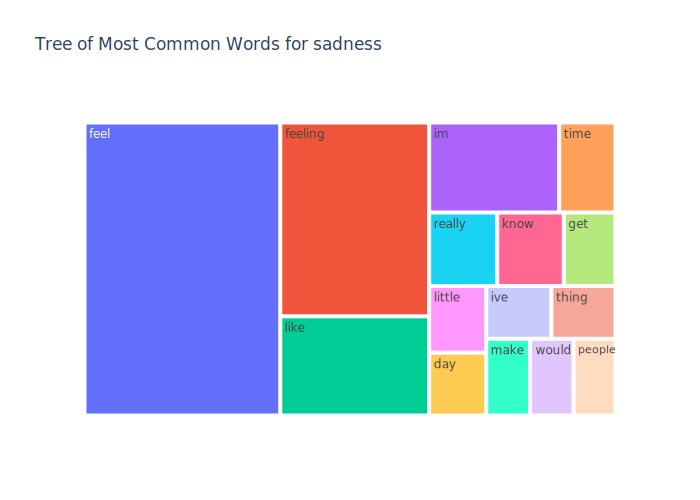

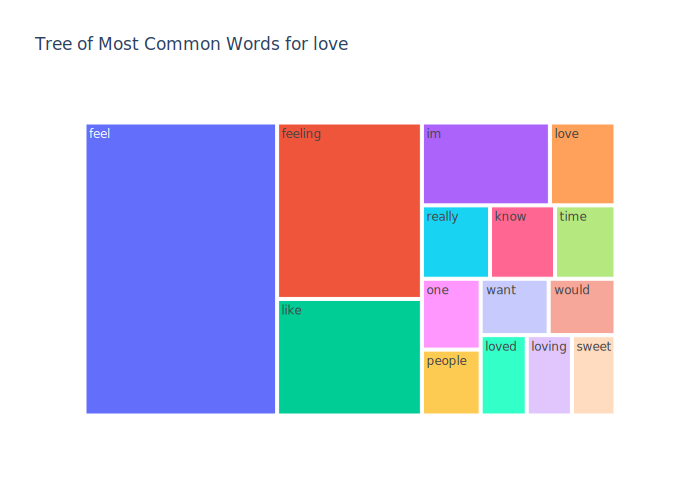

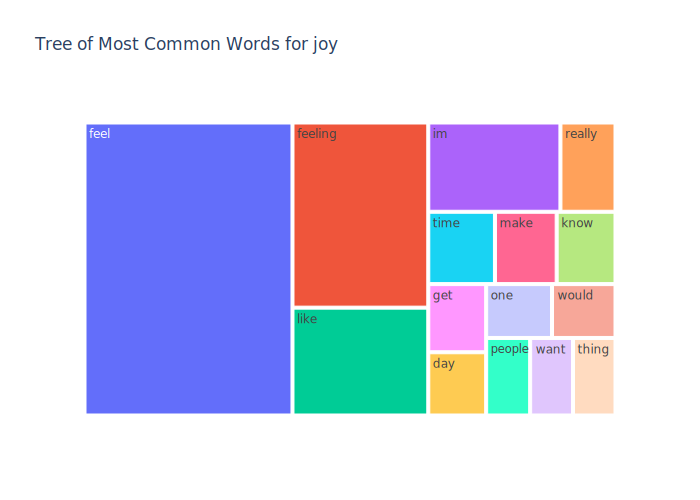

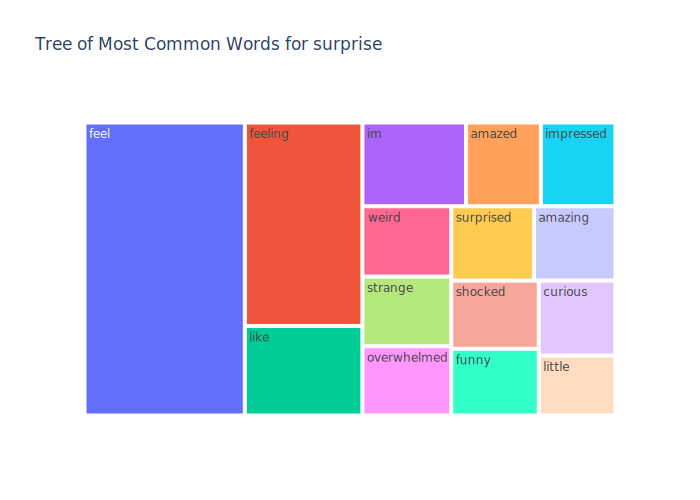

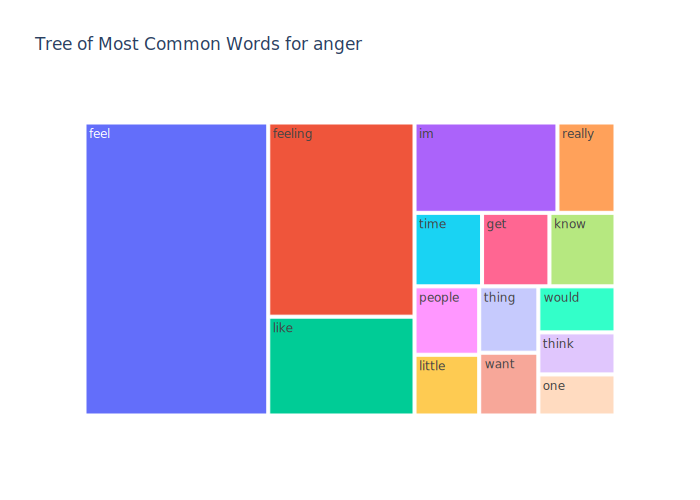

In [32]:
for emotion in emotions_df["label_decoded"].unique():
  common_words_by_emotion(emotion)

Comparing those plots, there is a noticable resemblance in most popular words among all emotions. "Feel" and "feeling" take the lead, which is not surprising. The next two most common words - "like" and "im" are also shared, but apart from that, there is a visible difference. "Im" is frequently used to express personal feelings or experiences in first-person narratives, and "like" is a word often used for comparisons and similes to vividly express feelings or experiences.
When it comes to other prominent words, words associated with text classified as "surprise" seem to stand out, as there are a lot of adjectives present that express emotions.

The infrequent occurrence of surprise in the dataset, as it is the least represented class, may be attributed to the intensity of the language used to describe it compared to other emotions. The distinctiveness of the most common words associated with surprise compared to those of other emotions suggests a unique linguistic pattern for surprise within the dataset

Another emotion that displays some variation is "love," characterized by the presence of love-related words, though not to the same extent.

When it comes to other emotions, the most prevalent words are less specific and may not distinctly reflect emotional states.